In [1]:
"""
                                PROCESAMIENDO DIGITAL DE SEÑALES: TP2

                                Alumno: Julián Luongo

                                Software Utilizado: Visual Studio Code,Lenguaje Python

                                Hardware:
                                CPU: Intel Core i5 12600k
                                Ram:16gb
"""
from pylab import *
from pylab import zeros
import math
import random
import struct
from scipy import signal as sg
import scipy
from scipy import special as sp
import numpy as np
from numpy.fft import rfft, irfft
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import cv2
import scipy.io.wavfile as wav
import IPython
from collections import Counter

In [2]:
''' SE RECOMIENDA BORRAR TODAS LAS VARIABLES ANTES DE EJECUTAR EL CÓDIGO '''

#SE DEFINEN LAS FUNCIONES A UTILIZAR:

def most_frequent(List):

    'Program to find most frequent element in a list'

    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

def SNR(original, marcado):
    
    def signalPower(x):
        return np.mean(x**2)
    
    inputSig = original
    outputSig = marcado[0:len(original)]


    noise1 = outputSig-inputSig
    

    powS1 = signalPower(outputSig)
    powN1 = signalPower(noise1)
    return 10*np.log10((abs((powS1-powN1))/powN1))

def cross_corr(imagen_original,imagen_obtenida):
    a=imagen_original.flatten()
    b=imagen_obtenida.flatten()
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    return max(np.correlate(a, b, 'full'))



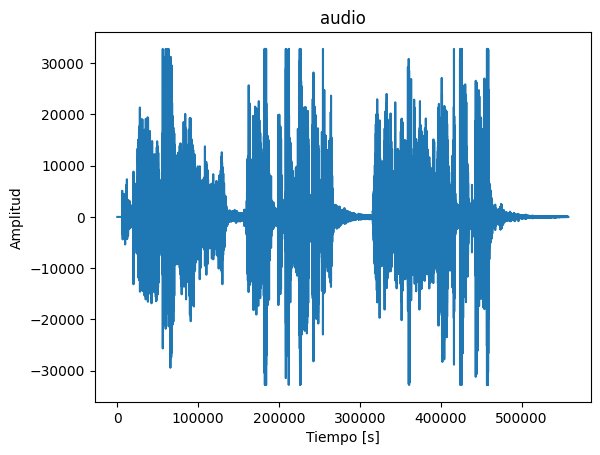

frecuencia de muestreo : 44100


In [3]:
'''
PROCEDIMIENTO PARA DETECCIÓN
'''

#PASO 1: se lee el audio con el watermark.

audio_location=r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\audio_marcado.wav'
fs_audio, audio = wav.read(audio_location)
n=np.arange(0,len(audio))
plt.figure()
plt.plot(n,audio)
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.title('audio')  
plt.show()

print('frecuencia de muestreo : ' + str(fs_audio))
IPython.display.Audio("audio_marcado.wav")


In [4]:
#PASO 2: se importan los archivos para recuperar la marca

bps = np.loadtxt(r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\bps.csv',delimiter=',')    #Información de a cuantos bps se marcó el audio y de las dimensiones de la imágen.
Dxx = np.loadtxt(r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\Dxx.csv',delimiter=',')    #Importación de la matriz Dxx, necesaria para la detección.
key = np.loadtxt(r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\key.csv',delimiter=',')    #Importación de la contraseña.
false_key = np.loadtxt(r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\false_key.csv',delimiter=',')    #Importación de la falsa contraseña.
a = np.loadtxt(r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\strength_factor.csv',delimiter=',')    #factor de fuerza.


bps = int(bps[0])
a = a[0]



C:\Users\Julian\AppData\Local\Temp\ipykernel_35412\2418033603.py:13: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(t, f, np.log10(np.abs(Pxx)))       #Se plotea la STFT


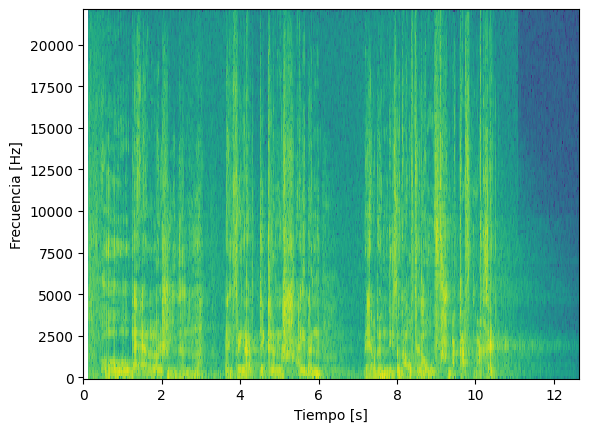

True


In [5]:
#PASO 3: STFT al audio para la detección.
Ventana ='blackman'                                    #CAMBIAR ACÁ EL TIPO DE VENTANA PARA LA STFT
m=256                                                  #ancho de la ventana
overlap = m // 2
nfft = m
return_onesided = True

f,t,Pxx = sg.stft(audio,fs=fs_audio,window=Ventana,nperseg=m,nfft=nfft,noverlap=overlap,return_onesided=return_onesided)         #STFT

fig,ax = plt.subplots()
ax.set_ylabel('Frecuencia [Hz]')
ax.set_xlabel('Tiempo [s]')
ax.pcolormesh(t, f, np.log10(np.abs(Pxx)))       #Se plotea la STFT
plt.show()

print(sg.check_NOLA(Ventana,m,overlap))                         

In [6]:

#PASO 4: Proceso de detección de bits del Watermark para cada Frame de STFT.

real_w = key       # PARA PRUEBAS DE DETECCIÓN, CAMBIAR ACÁ LA CLAVE

frame_width = overlap // bps

ind = np.arange(0, len(Pxx)-frame_width+1, frame_width, dtype = int)  # Determina donde empezar a fragmentar la STFT.

bits = []
#Por cada frame:
for f in range(len(ind)):
    
    frame = Pxx[ind[f]:ind[f]+frame_width]
    detection_frame = Dxx[ind[f]:ind[f]+frame_width]

    u, dw, vt = np.linalg.svd(frame,full_matrices=True)   #SVD a cada frame para obtener Dw.
    dw = scipy.linalg.diagsvd(dw,len(u),len(vt))      #Matriz Dw.

    uw, d, vw = np.linalg.svd(detection_frame,full_matrices=True)  #SVD a cada frame de Dxx para obtener "uw", "d" y "vw".
    d = scipy.linalg.diagsvd(d,len(uw),len(vw))       #Matriz D.

    wd = np.matmul( np.matmul( uw, dw, dtype=float ), vw, dtype=float )     #Matriz Wd.

    real_w_inv = np.zeros(real_w.shape,dtype=float)    # 1/Key.
    for i in range(len(real_w)):      
            real_w_inv[i] = (1. / real_w[i])

    bit_matrix = np.multiply((wd-d)*(1./a),real_w_inv,dtype=float)     #Se obtiene matriz llena del bit marcado
    detection=(bit_matrix).flatten()    

    bits.append(most_frequent(detection))    #Nos quedamos con el bit mas frecuente.
      


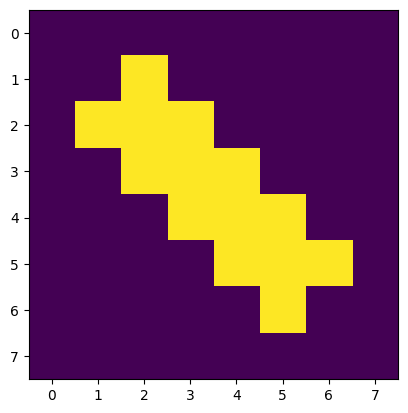

In [7]:
#PASO 5: RECONSTRUCCIÓN DE LA IMAGEN
bits = np.reshape(bits, (int(np.sqrt(bps)),int(np.sqrt(bps))))
plt.figure()
plt.imshow(bits)
resultado=bits
resultado[abs(resultado) > 0] = 1   #OBTENEMOS LOS BITS 0,1 DE LA IMAGEN.

SNR: 29.879515866051378 
Correlation: 1.0


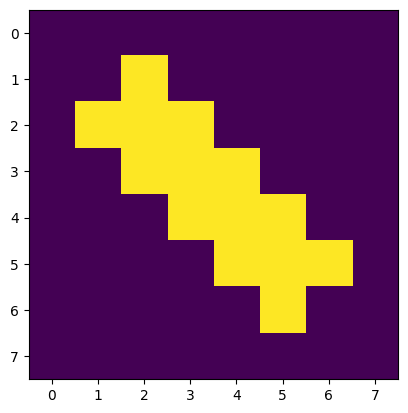

In [8]:
'''
RESULTADO DE LA DETECCIÓN Y PRUEBAS
'''
plt.figure()
plt.imshow(resultado)

#CARGA DE IMAGEN ORIGINAL PARA PRUEBA DE CORRELACION
image_location=r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\image.jpg'      
original = cv2.imread(image_location,0)   #Se lee la imagen en escala de grises (1 canal)
ret, original_bw = cv2.threshold(original,127,255,cv2.THRESH_BINARY) #se pasa la imagen a binarios(blanco y negro)
original_bw=(1/255)*original_bw    #el binario de [0,255] pasa a ser [0,1].

#CARGA DE AUDIO ORIGINAL PARA PRUEBA DE SNR
audio_original = np.loadtxt(r'D:\Coding\Python\UNTREF\PDS\TP2_Luongo\audio_original.csv',delimiter=',')

signal_noise = SNR(audio_original,audio[0:len(audio_original)])
correl=cross_corr(original_bw,bits)

print("SNR: {} ".format(signal_noise))
print("Correlation: {}".format(correl))